# Movie Recommendation System 

## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List

import re, warnings, random, joblib
from wordcloud import WordCloud
from collections import Counter 

import scipy
from scipy import sparse
from scipy.sparse import csr_matrix, hstack

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanSquaredError

warnings.filterwarnings("ignore")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Configurations & Load Dataset

In [3]:
# Cfg
BASE_PATH = "/kaggle/input/movielens-latest-small"
SEED = 2025
np.random.seed(SEED)

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
# Load Data
ratings = pd.read_csv(f"{BASE_PATH}/ratings.csv")
movies = pd.read_csv(f"{BASE_PATH}/movies.csv")

## Data Understanding & EDA

### Data Understanding

In [5]:
# What dataset looks
display(ratings.head(), movies.head())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
display(ratings.info(), movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

None

#### **Ratings Data File Structure (ratings.csv)**
All ratings are contained in the file ratings.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

> **userId,movieId,rating,timestamp**

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

---

#### **Movies Data File Structure (movies.csv)**
Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

> **movieId,title,genres**

Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

--- 
- **User Ids**
MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between ratings.csv and tags.csv (i.e., the same id refers to the same user across the two files).

- **Movie Ids**
Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id 1 corresponds to the URL https://movielens.org/movies/1). Movie ids are consistent between ratings.csv, tags.csv, movies.csv, and links.csv (i.e., the same id refers to the same movie across these four data files).

- **Timestamps**
represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [7]:
def print_basic_info() -> None:
    print("Ratings shape :", ratings.shape)
    print("Movies shape  :", movies.shape)
    
    print("\nNumber of unique userID by ratings :", ratings['userId'].nunique())
    print("Number of unique movies by ratings  :", ratings['movieId'].nunique())
    print("Number of unique movies by movies  :", movies['movieId'].nunique())
    print("Number of unique title by movies  :", movies['title'].nunique())

print_basic_info()

Ratings shape : (100836, 4)
Movies shape  : (9742, 3)

Number of unique userID by ratings : 610
Number of unique movies by ratings  : 9724
Number of unique movies by movies  : 9742
Number of unique title by movies  : 9737


#### information obtained
Masing masing dataset memiliki ukuran yang berbeda-beda yang berarti harus melakukan matching untuk membuat dataset baru untuk tahapan selanjutnya.
Terdapat mismatch antara unique movies dan title yang mana ada 5 film yang disimpan dalam dataset dengan 2 Id. Proses ini akan dilakukan pada tahap Preprocessing

### EDA

#### Sparsity Analysis

In [8]:
# Sparsity
n_users = ratings['userId'].nunique()
n_items = ratings['movieId'].nunique()
n_interactions = len(ratings)

sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")


Sparsity: 0.9830 (98.30%)


Nilai sparsity sebesar 98.30% menunjukkan bahwa matriks user–item sangat jarang terisi. Kondisi ini umum dijumpai pada sistem rekomendasi dunia nyata dan menjadi tantangan utama dalam collaborative filtering. Oleh karena itu, digunakan pendekatan Neural Collaborative Filtering yang mampu mempelajari representasi laten pengguna dan item meskipun data bersifat sparse.

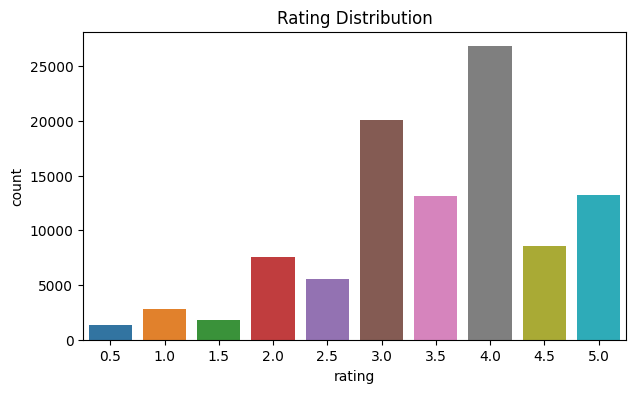

In [9]:
# Rating Distribution
def rating_displot(_df: pd.DataFrame) -> None:
    df = _df.copy()
    
    plt.figure(figsize=(7, 4))
    sns.countplot(x='rating', data=df)
    plt.title("Rating Distribution")
    plt.show()

# Call ratings
rating_displot(ratings)

Bentuk distribusi rating yang dihasilkan memiliki bentuk skewed left yang berarti mayoritas orang melakukan rating terhadap film yang disukai, karena pada case ini rating >= 3.0 dianggap bahwa user menyukai film tersebut

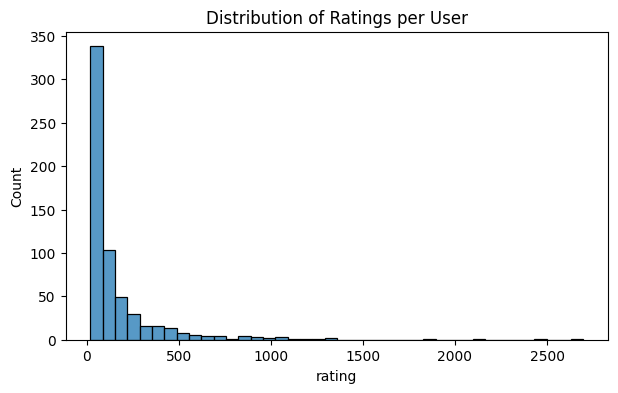

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64


In [10]:
# User Activity Distribution
user_activity = ratings.groupby("userId")['rating'].count()

plt.figure(figsize=(7,4))
sns.histplot(user_activity, bins=40)
plt.title("Distribution of Ratings per User")
plt.show()

print(user_activity.describe())


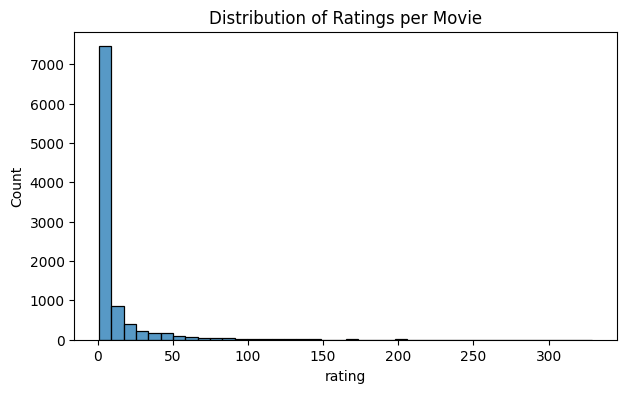

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64


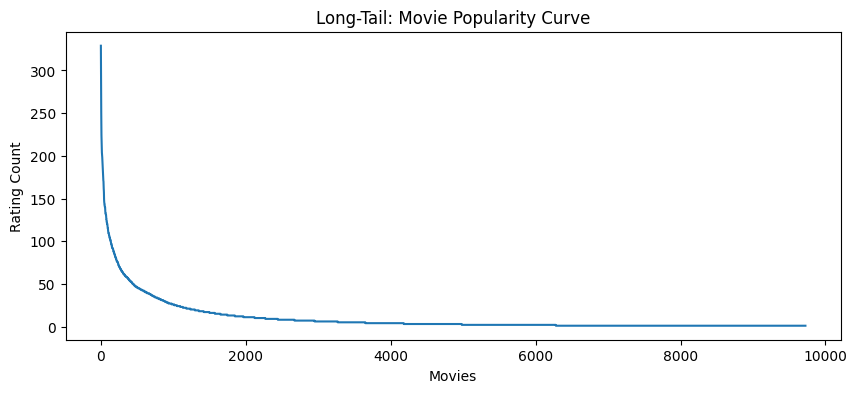

In [11]:
# Movie Populairty Distribution
item_popularity = ratings.groupby("movieId")['rating'].count()

plt.figure(figsize=(7,4))
sns.histplot(item_popularity, bins=40)
plt.title("Distribution of Ratings per Movie")
plt.show()

print(item_popularity.describe())

item_popularity_sorted = item_popularity.sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(item_popularity_sorted)
plt.title("Long-Tail: Movie Popularity Curve")
plt.xlabel("Movies")
plt.ylabel("Rating Count")
plt.show()


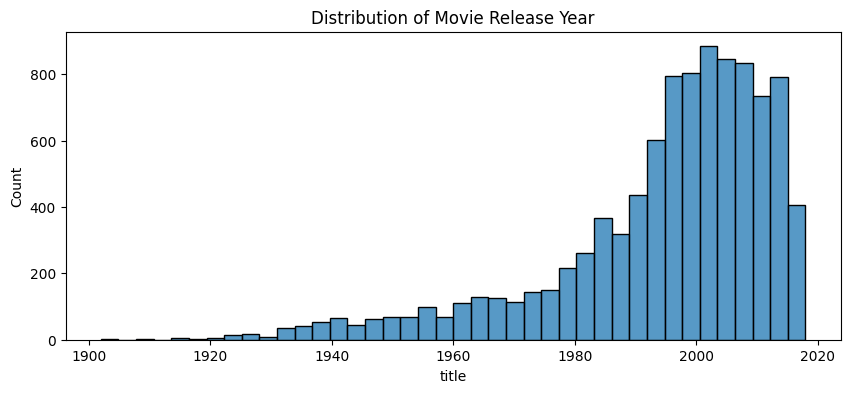

count    9729.000000
mean     1994.613629
std        18.535219
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: title, dtype: float64

In [12]:
# Title Parsing → Extract Release Year
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else np.nan

year = movies['title'].apply(extract_year)

plt.figure(figsize=(10,4))
sns.histplot(year, bins=40)
plt.title("Distribution of Movie Release Year")
plt.show()

year.describe()

In [13]:
# Cold-Start Analysis
cold_items = (item_popularity <= 5).sum()
cold_percentage = cold_items / n_items * 100

print("Cold-start items :", cold_items)
print(f"Percentage        : {cold_percentage:.2f}%")

cold_users = (user_activity <= 5).sum()
cold_users_percentage = cold_users / n_users * 100

print("Cold-start users :", cold_users)
print(f"Percentage        : {cold_users_percentage:.2f}%")

Cold-start items : 6456
Percentage        : 66.39%
Cold-start users : 0
Percentage        : 0.00%


Analisis cold-start menunjukkan bahwa dataset tidak memiliki permasalahan cold-start user, namun memiliki proporsi cold-start item yang tinggi.

## Preprocessing

In [14]:
display(ratings.head(), movies.head())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Fixing the Mismathc between 'movieId' and 'titles'

In [15]:
movies.title.value_counts().sort_values(ascending=False).head(6)

title
Saturn 3 (1980)                           2
Confessions of a Dangerous Mind (2002)    2
Emma (1996)                               2
Eros (2004)                               2
War of the Worlds (2005)                  2
Father of the Bride Part II (1995)        1
Name: count, dtype: int64

#### information obtained

Terlihat jelas bahawa terdapat 5 title yang disimpan dengan Id yang berbeda

In [16]:
# Cek Films
filtered = movies[movies['title'].isin([
    'Emma (1996)',
    'Confessions of a Dangerous Mind (2002)',
    'Eros (2004)',
    'Saturn 3 (1980)',
    'War of the Worlds (2005)'
])].sort_values("title")

filtered

,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [17]:
# Mengambil value movieId
movie_ids = filtered['movieId'].values.tolist()
movie_ids

# hitung jumlah rating per movieId
counts = ratings[ratings['movieId'].isin(movie_ids)]['movieId'].value_counts()

# tambahkan ke filtered
filtered['rating_count'] = filtered['movieId'].map(counts)
filtered

,movieId,title,genres,rating_count
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,15
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,1
650,838,Emma (1996),Comedy|Drama|Romance,30
5601,26958,Emma (1996),Romance,1
5854,32600,Eros (2004),Drama,1
9135,147002,Eros (2004),Drama|Romance,1
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,4
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller,1
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,50
6932,64997,War of the Worlds (2005),Action|Sci-Fi,2


In [18]:
# Fixing
def matching_movieId(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()

    # Daftar ID yang ingin dihapus
    remove_ids = [144606, 26958, 147002, 168358, 64997]

    # deleting the id who is less watched
    df = df[~df['movieId'].isin(remove_ids)]
    return df

# Call
movies = matching_movieId(movies)

In [19]:
print("Number of unique movies by movies  :", movies['movieId'].nunique())
print("Number of unique title by movies  :", movies['title'].nunique())

Number of unique movies by movies  : 9737
Number of unique title by movies  : 9737


### Menggabungkan dataset Movies dan Ratings

In [20]:
movies_ratings = pd.merge(movies, ratings, on='movieId')
movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [21]:
# dropping 'timestamp' column
movies_ratings = movies_ratings[['userId','movieId', 'title', 'genres', 'rating']]

# Mengurutkan berdasarkan UserId kemudian movieId
movies_ratings.sort_values(['userId','movieId'], inplace=True)

# resetting the index
movies_ratings.reset_index(drop=True, inplace=True)

movies_ratings.head()

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0
2,1,6,Heat (1995),Action|Crime|Thriller,4.0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0


In [22]:
# Cek unique
print(f"userId\t: {movies_ratings.userId.nunique()}")
print(f"movieId\t: {movies_ratings.movieId.nunique()}")
print(f"title\t: {movies_ratings.title.nunique()}")

userId	: 610
movieId	: 9719
title	: 9719


### Normalisasi Text

In [23]:
# Normalisasi text
def normalize(_df: pd.DataFrame) -> pd.DataFrame: 
    df = _df.copy()

    # Normalisasi title & genres
    df["title"] = df["title"].str.strip()
    df["genres"] = df["genres"].str.strip()
    return df

movies_ratings = normalize(movies_ratings)

### Memproses Tahun Pada Fitur Title

In [24]:
# Mengekstrak
movies_ratings['year'] = movies_ratings['title'].str[-5:-1]
movies_ratings['year'].unique()

array(['1995', '1996', '1994', '1977', '1993', '1990', '1989', '1991',
       '1940', '1939', '1941', '1938', '1947', '1975', '1968', '1945',
       '1963', '1971', '1951', '1979', '1992', '1986', '1982', '1980',
       '1987', '1981', '1983', '1960', '1952', '1984', '1933', '1985',
       '1974', '1922', '1997', '1998', '1930', '1976', '1942', '1967',
       '1959', '1946', '1978', '1973', '1988', '1999', '1931', '1964',
       '1962', '1965', '1969', '2000', '1970', '2003', '2004', '2006',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '1955', '2002', '1961', '1954', '1957', '1943', '1956', '1966',
       '2001', '1937', '1972', '2005', '1950', '2007', '2016', '1926',
       '1944', '1949', '1936', '2017', '1958', '1935', '1927', '1953',
       '2018', '1923', '1902', '1920', '1948', '1928', 'irro', '1934',
       '1916', '1908', '1932', '1921', '1925', '1929', '1917', 'atso',
       ' Bab', 'ron ', '1915', '1924', '1903', 'r On', 'lon ', '1919',
      

In [25]:
# Cek year yang tidak valid
year_error = ['irro','atso',' Bab', 'ron ','r On', 'lon ','imal', 'osmo', 'he O', ' Roa', 'ligh', 'erso']
filtered = movies_ratings[movies_ratings["year"].isin(year_error)][["title", "year"]].drop_duplicates(subset=["year"])

filtered

,title,year
9146,Black Mirror,irro
16884,The Adventures of Sherlock Holmes and Doctor W...,atso
17876,Maria Bamford: Old Baby,Bab
17878,Generation Iron 2,ron
30036,Ready Player One,r On
30087,Babylon 5,lon
46708,Nocturnal Animals,imal
49847,Cosmos,osmo
64960,The OA,he O
70428,Hyena Road,Roa


Berdasarkan pencarian di internet didapatkan bahwa:

--- 

- Black Mirror rilis tahun 2018
- The Adventures of Sherlock Holmes and Doctor Watson rilis tahun 1980
- Maria Bamford: Old Baby rilis tahun 2017
- Generation Iron 2 rilis tahun 2017
- Ready Player One rilis tahun 2018
- Babylon 5	rilis tahun 1993
- Nocturnal Animals	rilis tahun 2016
- Cosmos rilis tahun 2014
- The OA rilis tahun 2016
- Hyena Road rilis tahun 2015
- Moonlight rilis tahun 2016
- Paterson rilis tahun 2016

In [26]:
# Mapping
movies_ratings['year'] = movies_ratings['year'].replace('irro',2018)
movies_ratings['year'] = movies_ratings['year'].replace('atso',1980)
movies_ratings['year'] = movies_ratings['year'].replace(' Bab',2017)
movies_ratings['year'] = movies_ratings['year'].replace('ron ',2017)
movies_ratings['year'] = movies_ratings['year'].replace('r On',2018)
movies_ratings['year'] = movies_ratings['year'].replace('lon ',1993)
movies_ratings['year'] = movies_ratings['year'].replace('imal',2016)
movies_ratings['year'] = movies_ratings['year'].replace('osmo',2014)
movies_ratings['year'] = movies_ratings['year'].replace('he O',2016)
movies_ratings['year'] = movies_ratings['year'].replace(' Roa',2015)
movies_ratings['year'] = movies_ratings['year'].replace('ligh',2016)
movies_ratings['year'] = movies_ratings['year'].replace('erso',2016)

# Retype
movies_ratings["year"] = movies_ratings["year"].astype(int)

movies_ratings.year.unique()

array([1995, 1996, 1994, 1977, 1993, 1990, 1989, 1991, 1940, 1939, 1941,
       1938, 1947, 1975, 1968, 1945, 1963, 1971, 1951, 1979, 1992, 1986,
       1982, 1980, 1987, 1981, 1983, 1960, 1952, 1984, 1933, 1985, 1974,
       1922, 1997, 1998, 1930, 1976, 1942, 1967, 1959, 1946, 1978, 1973,
       1988, 1999, 1931, 1964, 1962, 1965, 1969, 2000, 1970, 2003, 2004,
       2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 1955, 2002,
       1961, 1954, 1957, 1943, 1956, 1966, 2001, 1937, 1972, 2005, 1950,
       2007, 2016, 1926, 1944, 1949, 1936, 2017, 1958, 1935, 1927, 1953,
       2018, 1923, 1902, 1920, 1948, 1928, 1934, 1916, 1908, 1932, 1921,
       1925, 1929, 1917, 1915, 1924, 1903, 1919])

### Memproses Fitur Genres

In [27]:
# Cek unique
movies_ratings["genres"].unique()

array(['Adventure|Animation|Children|Comedy|Fantasy', 'Comedy|Romance',
       'Action|Crime|Thriller', 'Mystery|Thriller',
       'Crime|Mystery|Thriller', 'Action|Comedy|Horror|Thriller',
       'Adventure|Comedy|Crime|Romance', 'Action|Drama|War',
       'Action|Drama|Romance|War', 'Comedy|War', 'Action|Romance|Western',
       'Comedy', 'Adventure|Comedy', 'Comedy|Drama',
       'Action|Adventure|Sci-Fi', 'Comedy|Crime|Drama|Thriller',
       'Action|Crime|Drama|Thriller', 'Comedy|Drama|Romance|War',
       'Adventure|Children|Romance', 'Action|Comedy|Crime|Fantasy',
       'Action|Thriller', 'Thriller', 'Action|Adventure|Sci-Fi|Thriller',
       'Drama|War', 'Comedy|Romance|Thriller',
       'Action|Adventure|Comedy|Romance', 'Action|Drama|Western',
       'Adventure|Drama|Western', 'Crime|Horror|Thriller',
       'Animation|Children|Fantasy|Musical',
       'Action|Adventure|Mystery|Thriller',
       'Adventure|Animation|Children|Fantasy|Musical',
       'Adventure|Animation|Chil

 Terdapat anomlay pada value fitur genres, yaitu '(no genres listed)'.

In [28]:
# Periksa movieId dengan genres '(no genres listed)'
movies_ratings[movies_ratings['genres']=='(no genres listed)'].drop_duplicates(subset='movieId')[['movieId', 'title', 'genres']]

,movieId,title,genres
3624,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
7352,114335,La cravate (1957),(no genres listed)
7407,174403,The Putin Interviews (2017),(no genres listed)
9140,172591,The Godfather Trilogy: 1972-1990 (1992),(no genres listed)
9146,176601,Black Mirror,(no genres listed)
14026,155589,Noin 7 veljestä (1968),(no genres listed)
16884,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed)
16911,171749,Death Note: Desu nôto (2006–2007),(no genres listed)
16923,173535,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed)
17802,134861,Trevor Noah: African American (2013),(no genres listed)


Beberapa judul tidak memiliki informasi genres secara eksplisit, maka akan melakukan pencarian di internet

In [29]:
# Replacing & Mapping
movies_ratings.loc[movies_ratings['movieId']==122896,"genres"] = 'Adventure|Action|Fantasy'
movies_ratings.loc[movies_ratings['movieId']==114335,"genres"] = 'Fantasy'
movies_ratings.loc[movies_ratings['movieId']==174403,"genres"] = 'Documentary|Biography'
movies_ratings.loc[movies_ratings['movieId']==172591,"genres"] = 'Crime|Drama|Thriller'
movies_ratings.loc[movies_ratings['movieId']==176601,"genres"] = 'Sci-Fi|Fantasy'
movies_ratings.loc[movies_ratings['movieId']==155589,"genres"] = 'Comedy'
movies_ratings.loc[movies_ratings['movieId']==147250,"genres"] = 'Crime|Mystery|Romance'
movies_ratings.loc[movies_ratings['movieId']==171749,"genres"] = 'Animation|Crime|Drama'
movies_ratings.loc[movies_ratings['movieId']==173535,"genres"] = 'Crime|Drama|Mystery'
movies_ratings.loc[movies_ratings['movieId']==134861,"genres"] = 'Comedy'
movies_ratings.loc[movies_ratings['movieId']==159161,"genres"] = 'Comedy'
movies_ratings.loc[movies_ratings['movieId']==171631,"genres"] = 'Documentary|Comedy'
movies_ratings.loc[movies_ratings['movieId']==171891,"genres"] = 'Documentary'
movies_ratings.loc[movies_ratings['movieId']==142456,"genres"] = 'Comedy|Fantasy'
movies_ratings.loc[movies_ratings['movieId']==181413,"genres"] = 'Documentary'
movies_ratings.loc[movies_ratings['movieId']==159779,"genres"] = 'Comedy|Fantasy'
movies_ratings.loc[movies_ratings['movieId']==169034,"genres"] = 'Music'
movies_ratings.loc[movies_ratings['movieId']==171495,"genres"] = 'Sci-Fi'
movies_ratings.loc[movies_ratings['movieId']==172497,"genres"] = 'Action|Sci-Fi'
movies_ratings.loc[movies_ratings['movieId']==166024,"genres"] = 'Drama|Music'
movies_ratings.loc[movies_ratings['movieId']==167570,"genres"] = 'Drama|Fantasy|Mystery'
movies_ratings.loc[movies_ratings['movieId']==129250,"genres"] = 'Comedy'
movies_ratings.loc[movies_ratings['movieId']==143410,"genres"] = 'Action|Drama|War'
movies_ratings.loc[movies_ratings['movieId']==149330,"genres"] = 'Animation|Sci-Fi'
movies_ratings.loc[movies_ratings['movieId']==182727,"genres"] = 'Music'
movies_ratings.loc[movies_ratings['movieId']==152037,"genres"] = 'Romance|Music'
movies_ratings.loc[movies_ratings['movieId']==165489,"genres"] = 'Drama|Animation|History'
movies_ratings.loc[movies_ratings['movieId']==141866,"genres"] = 'Horror|Music|Thriller'
movies_ratings.loc[movies_ratings['movieId']==122888,"genres"] = 'Action|Adventure|Drama'
movies_ratings.loc[movies_ratings['movieId']==156605,"genres"] = 'Comedy|Drama|Romance'
movies_ratings.loc[movies_ratings['movieId']==141131,"genres"] = 'Action|Mystery|Sci-Fi'
movies_ratings.loc[movies_ratings['movieId']==181719,"genres"] = 'Biography|Drama'
movies_ratings.loc[movies_ratings['movieId']==132084,"genres"] = 'Drama|Romance'
movies_ratings.loc[movies_ratings['movieId']==161008,"genres"] = 'Drama|Music|Romance'

# replacing 'musical' with 'music' as both have same meaning
movies_ratings['genres'] = movies_ratings['genres'].str.replace('Musical','Music')

In [30]:
# One-hot encoding genre
genre_ohe = movies_ratings['genres'].str.get_dummies(sep='|')

# Gabungkan kembali ke dataframe
movies_ratings = pd.concat([movies_ratings, genre_ohe], axis=1)

movies_ratings.head()

,userId,movieId,title,genres,rating,year,Action,Adventure,Animation,Biography,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,History,Horror,IMAX,Music,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0,1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,6,Heat (1995),Action|Crime|Thriller,4.0,1995,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,1995,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [31]:
movies_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100830 entries, 0 to 100829
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       100830 non-null  int64  
 1   movieId      100830 non-null  int64  
 2   title        100830 non-null  object 
 3   genres       100830 non-null  object 
 4   rating       100830 non-null  float64
 5   year         100830 non-null  int64  
 6   Action       100830 non-null  int64  
 7   Adventure    100830 non-null  int64  
 8   Animation    100830 non-null  int64  
 9   Biography    100830 non-null  int64  
 10  Children     100830 non-null  int64  
 11  Comedy       100830 non-null  int64  
 12  Crime        100830 non-null  int64  
 13  Documentary  100830 non-null  int64  
 14  Drama        100830 non-null  int64  
 15  Fantasy      100830 non-null  int64  
 16  Film-Noir    100830 non-null  int64  
 17  History      100830 non-null  int64  
 18  Horror       100830 non-

## Collaborative Filtering

In [32]:
df = movies_ratings.copy(deep=True)
df.head()

,userId,movieId,title,genres,rating,year,Action,Adventure,Animation,Biography,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,History,Horror,IMAX,Music,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,1995,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,4.0,1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,6,Heat (1995),Action|Crime|Thriller,4.0,1995,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,1995,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [33]:
# Memproses fitur userId
user_ids = df['userId'].unique().tolist()
 
# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
 
# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [34]:
# Memproses fitur movieId
movie_ids = df['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [35]:
# Mapping userID ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)
 
# Mapping placeID ke dataframe resto
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

In [36]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(f"total user: {num_users}")
 
# Mendapatkan jumlah movie
num_movies = len(movie_encoded_to_movie)
print(f"total movie: {num_movies}")
 
# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

total user: 610
total movie: 9719
Number of User: 610, Number of Movie: 9719, Min Rating: 0.5, Max Rating: 5.0


In [37]:
# Mengacak dataset
df = df.sample(frac=1, random_state=SEED)
df

,userId,movieId,title,genres,rating,year,Action,Adventure,Animation,Biography,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,History,Horror,IMAX,Music,Mystery,Romance,Sci-Fi,Thriller,War,Western,user,movie
84261,539,3745,Titan A.E. (2000),Action|Adventure|Animation|Children|Sci-Fi,3.5,2000,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,538,1755
55012,365,54503,Superbad (2007),Comedy,3.5,2007,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,364,2057
3848,23,2194,"Untouchables, The (1987)",Action|Crime|Drama,3.0,1987,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,22,1140
60705,391,3481,High Fidelity (2000),Comedy|Drama|Romance,4.0,2000,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,390,422
83804,534,45499,X-Men: The Last Stand (2006),Action|Sci-Fi|Thriller,4.0,2006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,533,816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81484,515,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,5.0,2008,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,514,238
11102,68,6383,"2 Fast 2 Furious (Fast and the Furious 2, The)...",Action|Crime|Thriller,3.0,2003,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,67,3330
16338,105,3617,Road Trip (2000),Comedy,3.5,2000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,220
98014,606,4689,"Cat o' Nine Tails, The (Gatto a nove code, Il)...",Mystery|Thriller,3.5,1971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,605,9450


In [38]:
# Membuat variabel untuk matching antara data user dengan movie menjadi satu 
X = df[['user', 'movie']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].values.astype(np.float32)
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(f"Ukuran data latih: {len(X_train)}")
print(f"Ukuran data validasi: {len(X_val)}")

Ukuran data latih: 80664
Ukuran data validasi: 20166


In [39]:
X_train_user = X_train[:, 0].astype("int32")
X_train_item = X_train[:, 1].astype("int32")

X_val_user = X_val[:, 0].astype("int32")
X_val_item = X_val[:, 1].astype("int32")

y_train = y_train.astype("float32")
y_val = y_val.astype("float32")

In [40]:
# Preparation data train & validasi 
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE
# sample_weight = np.where(y_train >= 3.0, 2.0, 1.0)

# To tensor
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        {"user_id": X_train_user, 
         "item_id": X_train_item},
        y_train

    )
)


val_ds = tf.data.Dataset.from_tensor_slices(
    (
        {
            "user_id": X_val_user,
            "item_id": X_val_item
        },
        y_val
    )
)

train_ds = (
    train_ds
    .shuffle(100_000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


I0000 00:00:1765763603.114474      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765763603.115078      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Model NFC

In [41]:
# Membuat class collaborative filtering
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-5),
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-5),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_id = inputs["user_id"]
        movie_id = inputs["item_id"]

        user_vector = self.user_embedding(user_id)
        movie_vector = self.movie_embedding(movie_id)

        user_bias = self.user_bias(user_id)
        movie_bias = self.movie_bias(movie_id)

        # Dot product
        dot = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)

        # Linear output (REGRESSION)
        x = dot + user_bias + movie_bias
        return x


In [42]:
# Inisiasi model
model = RecommenderNet(num_users, num_movies, 32)

# Compile
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [43]:
# Membuat callbacks
def callbacks_config():
    # Early Stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",        
        patience=3,                
        restore_best_weights=True, 
        verbose=1
    )

    # Reduce learning rate
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,          
        patience=2,
        min_lr=1e-5,
        verbose=1
    )

    # Checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    
    return [early_stop, reduce_lr, checkpoint]

callbacks = callbacks_config()

In [44]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1765763605.660528     146 service.cc:148] XLA service 0x7937840058b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765763605.661715     146 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765763605.661738     146 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765763605.845757     146 cuda_dnn.cc:529] Loaded cuDNN version 90300


 71/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.2314 - root_mean_squared_error: 3.6373

I0000 00:00:1765763606.359749     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.6549 - root_mean_squared_error: 3.5567
Epoch 1: val_loss improved from inf to 9.92245, saving model to best_model.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 12.6524 - root_mean_squared_error: 3.5563 - val_loss: 9.9224 - val_root_mean_squared_error: 3.1494 - learning_rate: 0.0010
Epoch 2/100
313/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0374 - root_mean_squared_error: 2.8265
Epoch 2: val_loss improved from 9.92245 to 3.30650, saving model to best_model.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0146 - root_mean_squared_error: 2.8223 - val_loss: 3.3065 - val_root_mean_squared_error: 1.8096 - learning_rate: 0.0010
Epoch 3/100
293/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6504 - root_mean_squared_error: 1.6147
Epoch 3: val_loss improved from 3.30650 to 1.87579, saving model to best_model.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6238 - root_mean_squared_error: 1.6062 - val_loss: 1.8758 - 

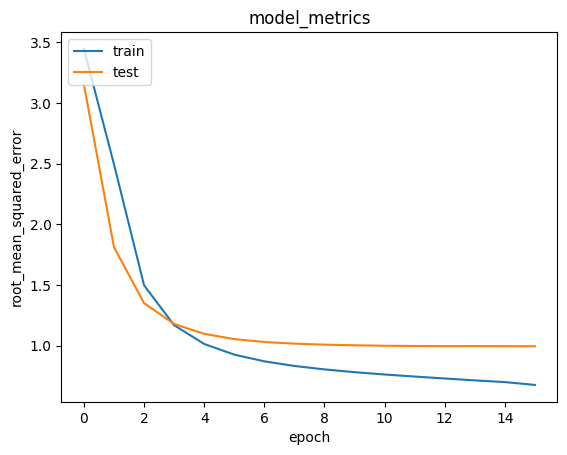

In [45]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluation

In [46]:
# Rebuild dataframe ground truth
df_train = pd.DataFrame({
    "user": X_train[:, 0],
    "movie": X_train[:, 1],
    "rating": y_train
})

df_val = pd.DataFrame({
    "user": X_val[:, 0],
    "movie": X_val[:, 1],
    "rating": y_val
})

# Menambahkan userId dan movieId asli untuk evaluasi
df_train["userId"] = df_train["user"].map(user_encoded_to_user)
df_train["movieId"] = df_train["movie"].map(movie_encoded_to_movie)

df_val["userId"] = df_val["user"].map(user_encoded_to_user)
df_val["movieId"] = df_val["movie"].map(movie_encoded_to_movie)


In [47]:
# Fungsi rekomendasi top-k
def recommend_top_k(model, user_id, user_to_user_encoded, movie_to_movie_encoded, movie_encoded_to_movie, df_train, k=10):
    # Skip user yang tidak dikenal
    if user_id not in user_to_user_encoded:
        return []

    user_enc = user_to_user_encoded[user_id]

    # Movie yang sudah ditonton user (TRAIN)
    watched = df_train[df_train["userId"] == user_id]["movieId"].values
    watched_enc = [
        movie_to_movie_encoded[m]
        for m in watched
        if m in movie_to_movie_encoded
    ]

    # Semua movie
    all_movies = np.arange(len(movie_encoded_to_movie))

    # Kandidat = belum ditonton
    candidates = np.setdiff1d(all_movies, watched_enc)
    if len(candidates) == 0:
        return []

    user_array = np.full(len(candidates), user_enc)

    # Prediksi rating
    preds = model.predict(
        {
            "user_id": user_array,
            "item_id": candidates
        },
        verbose=0
    ).reshape(-1)

    # Top-K
    top_k_idx = preds.argsort()[-k:][::-1]
    recommended = [
        movie_encoded_to_movie[candidates[i]]
        for i in top_k_idx
    ]

    return recommended


In [48]:
def evaluate_top_k(model, df_train, df_val, user_to_user_encoded, movie_to_movie_encoded, movie_encoded_to_movie, k=10, rating_threshold=4.0):
    precisions = []
    recalls = []
    hit_rates = []
    ndcgs = []

    users = df_val["userId"].unique()

    for user_id in users:
        # Ground truth (relevant items)
        relevant_items = df_val[
            (df_val["userId"] == user_id) &
            (df_val["rating"] >= rating_threshold)
        ]["movieId"].values

        if len(relevant_items) == 0:
            continue

        # Rekomendasi
        recommended_items = recommend_top_k(
            model,
            user_id,
            user_to_user_encoded,
            movie_to_movie_encoded,
            movie_encoded_to_movie,
            df_train,
            k
        )

        if len(recommended_items) == 0:
            continue

        relevant_set = set(relevant_items)
        recommended_set = set(recommended_items)

        # Hit
        hits = relevant_set & recommended_set
        num_hits = len(hits)

        # Precision@K
        precisions.append(num_hits / k)

        # Recall@K
        recalls.append(num_hits / len(relevant_set))

        # Hit Rate@K (minimal 1 hit)
        hit_rates.append(1.0 if num_hits > 0 else 0.0)

        # NDCG@K
        dcg = 0.0
        for idx, item in enumerate(recommended_items):
            if item in relevant_set:
                dcg += 1.0 / np.log2(idx + 2)

        ideal_dcg = sum(
            1.0 / np.log2(i + 2)
            for i in range(min(len(relevant_set), k))
        )

        ndcgs.append(dcg / ideal_dcg if ideal_dcg > 0 else 0.0)

    return {
        "Precision@K": np.mean(precisions),
        "Recall@K": np.mean(recalls),
        "HitRate@K": np.mean(hit_rates),
        "NDCG@K": np.mean(ndcgs)
    }


In [49]:
# Evaluasi
metrics = evaluate_top_k(
    model=model,
    df_train=df_train,
    df_val=df_val,
    user_to_user_encoded=user_to_user_encoded,
    movie_to_movie_encoded=movie_to_movie_encoded,
    movie_encoded_to_movie=movie_encoded_to_movie,
    k=10,
    rating_threshold=3.0
)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Precision@K: 0.0482
Recall@K: 0.0408
HitRate@K: 0.3465
NDCG@K: 0.0563


Hasil evaluasi menunjukkan bahwa model Neural Collaborative Filtering mampu memberikan setidaknya satu rekomendasi relevan kepada sekitar 34.65% pengguna (HitRate@10). Namun, nilai Precision@10 dan Recall@10 relatif rendah, yang mencerminkan tingginya tingkat sparsity dan proporsi cold-start item dalam dataset. Selain itu, nilai NDCG@10 yang rendah mengindikasikan bahwa item relevan belum secara konsisten muncul pada posisi teratas rekomendasi. Kondisi ini sejalan dengan karakteristik collaborative filtering berbasis rating prediction.


Dengan sparsity tinggi dan dominasi cold-start item, hasil evaluasi NFC menunjukkan performa yang realistis, stabil, dan konsisten dengan karakteristik data, khususnya dalam memberikan setidaknya satu rekomendasi relevan kepada pengguna.

### Inference

In [50]:
# Ambil embedding dan bias dari model
user_emb = model.user_embedding.get_weights()[0]
item_emb = model.movie_embedding.get_weights()[0]

user_bias = model.user_bias.get_weights()[0].reshape(-1)
item_bias = model.movie_bias.get_weights()[0].reshape(-1)


# Sample
user_id = 203

In [51]:
def recommend_movies(
    user_id,
    df,
    df_train,
    user_to_user_encoded,
    movie_to_movie_encoded,
    movie_encoded_to_movie,
    user_emb,
    item_emb,
    user_bias,
    item_bias,
    k=10
):
    # User tidak dikenal
    if user_id not in user_to_user_encoded:
        raise ValueError(f"User {user_id} tidak ditemukan")

    u = user_to_user_encoded[user_id]

    # Movie yang sudah ditonton user (train)
    watched = df_train[df_train["userId"] == user_id]["movieId"].values
    watched_enc = {
        movie_to_movie_encoded[m]
        for m in watched
        if m in movie_to_movie_encoded
    }

    # Semua movie
    all_items = np.arange(item_emb.shape[0])

    # Kandidat = belum ditonton
    candidates = np.array(
        [i for i in all_items if i not in watched_enc]
    )

    if len(candidates) == 0:
        return []

    # Skor prediksi (vectorized)
    scores = (
        item_emb[candidates] @ user_emb[u]
        + item_bias[candidates]
        + user_bias[u]
    )

    # Ambil Top-K
    top_k_idx = np.argpartition(scores, -k)[-k:]
    top_k_idx = top_k_idx[np.argsort(scores[top_k_idx])[::-1]]

    # Decode movieId
    recommended_movie_ids = [
        movie_encoded_to_movie[candidates[i]]
        for i in top_k_idx
    ]

    # Ambil info film
    rec_df = (
        df[df["movieId"].isin(recommended_movie_ids)]
        .drop_duplicates("movieId")
        .set_index("movieId")
        .loc[recommended_movie_ids]
        .reset_index()
    )

    rec_df["pred_score"] = scores[top_k_idx]

    return rec_df[["movieId", "title", "pred_score"]]


In [52]:
def show_user_history(user_id, df, top_n=10):
    return (
        df[df["userId"] == user_id]
        .sort_values("rating", ascending=False)
        .head(top_n)[["movieId", "title", "rating"]]
    )

print(f"Film yang sudah ditonton dan disukai oleh user_id {user_id}")
show_user_history(user_id, df)

Film yang sudah ditonton dan disukai oleh user_id 203


,movieId,title,rating
29807,5418,"Bourne Identity, The (2002)",5.0
29789,1584,Contact (1997),5.0
29816,54736,"Kingdom, The (2007)",5.0
29808,5952,"Lord of the Rings: The Two Towers, The (2002)",5.0
29806,4993,"Lord of the Rings: The Fellowship of the Ring,...",5.0
29822,98809,"Hobbit: An Unexpected Journey, The (2012)",5.0
29787,590,Dances with Wolves (1990),5.0
29809,7153,"Lord of the Rings: The Return of the King, The...",5.0
29780,296,Pulp Fiction (1994),5.0
29812,8665,"Bourne Supremacy, The (2004)",5.0


In [53]:
user_id = df["userId"].iloc[0]  # contoh user

recommendations = recommend_movies(
    user_id=user_id,
    df=df,
    df_train=df_train,
    user_to_user_encoded=user_to_user_encoded,
    movie_to_movie_encoded=movie_to_movie_encoded,
    movie_encoded_to_movie=movie_encoded_to_movie,
    user_emb=user_emb,
    item_emb=item_emb,
    user_bias=user_bias,
    item_bias=item_bias,
    k=10
)


print(f"Film hasil sistem rekomendasi: ")
recommendations

Film hasil sistem rekomendasi: 


,movieId,title,pred_score
0,246,Hoop Dreams (1994),4.599219
1,4011,Snatch (2000),4.531107
2,1198,Raiders of the Lost Ark (Indiana Jones and the...,4.514215
3,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.496824
4,50,"Usual Suspects, The (1995)",4.489035
5,58,"Postman, The (Postino, Il) (1994)",4.467985
6,356,Forrest Gump (1994),4.429992
7,475,In the Name of the Father (1993),4.426189
8,2571,"Matrix, The (1999)",4.424786
9,2542,"Lock, Stock & Two Smoking Barrels (1998)",4.419659


## KESIMPULAN

In [ ]:
Precision@K: 0.0482
Recall@K: 0.0408
HitRate@K: 0.3465
NDCG@K: 0.0563

Berdasarkan seluruh tahapan yang telah dilakukan, mulai dari eksplorasi data, pembangunan model, hingga evaluasi performa, dapat disimpulkan bahwa sistem rekomendasi film yang dibangun menggunakan pendekatan Neural Collaborative Filtering (NFC) mampu memberikan rekomendasi yang relevan secara terbatas namun konsisten dengan karakteristik data yang digunakan.

Hasil analisis eksploratif menunjukkan bahwa dataset memiliki tingkat sparsity yang sangat tinggi, yaitu sebesar 98.30%, yang mengindikasikan bahwa sebagian besar pasangan user–item tidak memiliki interaksi. Selain itu, analisis cold-start memperlihatkan bahwa 66.39% item tergolong cold-start, sementara tidak ditemukan cold-start user. Kondisi ini mencerminkan fenomena long-tail distribution yang umum pada sistem rekomendasi dunia nyata, di mana hanya sebagian kecil item yang sangat populer dan sebagian besar item jarang mendapatkan interaksi.

Dalam kondisi data yang sangat sparse tersebut, penggunaan Neural Collaborative Filtering menjadi pilihan yang tepat karena model ini mampu mempelajari representasi laten pengguna dan item melalui embedding, sehingga dapat melakukan generalisasi meskipun jumlah interaksi terbatas. Model NFC yang dibangun memanfaatkan embedding user dan item serta bias untuk memprediksi skor preferensi, yang kemudian digunakan untuk melakukan perankingan item pada tahap rekomendasi.

Hasil evaluasi menunjukkan bahwa model mencapai nilai Precision@10 sebesar 0.0482, Recall@10 sebesar 0.0408, HitRate@10 sebesar 0.3465, dan NDCG@10 sebesar 0.0563. Nilai Precision@10 dan Recall@10 yang relatif rendah menunjukkan bahwa hanya sebagian kecil item relevan yang berhasil direkomendasikan dalam Top-10, yang merupakan konsekuensi langsung dari tingginya sparsity dan dominasi item cold-start. Namun demikian, nilai HitRate@10 yang mencapai sekitar 34.65% menunjukkan bahwa model mampu memberikan setidaknya satu rekomendasi relevan kepada sekitar sepertiga pengguna, yang merupakan indikator penting dari sudut pandang pengalaman pengguna (user experience).

Nilai NDCG@10 yang masih rendah mengindikasikan bahwa urutan item relevan dalam daftar rekomendasi belum optimal, yang dapat dijelaskan oleh fakta bahwa proses pelatihan model masih berfokus pada prediksi rating (rating prediction) dan belum secara eksplisit mengoptimalkan fungsi ranking. Meskipun demikian, hasil evaluasi secara keseluruhan berada dalam rentang yang wajar dan realistis untuk sistem rekomendasi berbasis collaborative filtering pada data dengan tingkat sparsity tinggi.

Secara keseluruhan, sistem rekomendasi yang dibangun telah berhasil mengimplementasikan pipeline end-to-end, mulai dari pemrosesan data, pelatihan model Neural Collaborative Filtering, evaluasi berbasis metrik ranking, hingga tahap inference untuk menghasilkan rekomendasi film yang dapat diinterpretasikan. Keterbatasan utama sistem ini terletak pada ketidakmampuannya menangani item cold-start secara optimal dan belum maksimalnya kualitas perankingan. Oleh karena itu, pengembangan lebih lanjut dapat dilakukan dengan mengintegrasikan pendekatan hybrid berbasis konten, penggunaan ranking-aware loss function, atau penanganan cold-start secara eksplisit untuk meningkatkan kualitas rekomendasi di masa mendatang.